# What's SP500 next day stock price trend (classification)?

In [44]:
%matplotlib inline 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pycon9 import fit_scaler, scale, prepare_classification_samples, binary_conf_matrix, plot_loss, plot_acc

WINDOW = 7
TEST_SIZE = 0.2
RANDOM_SEED = 42 #it makes results reproducible: use only for test!!!
#RANDOM_SEED = None #uncomment me for real training!!!

def prepare_SP500_sv_data(verbose=0):
    df = pd.read_csv('/data/historical-SP500.csv', index_col='Date', parse_dates=True).sort_index()
    df = df[df.index.values > np.datetime64('2000-01-01')]
    close = df['Close'][0:(1250+WINDOW+1)]
    fit_scaler(close, TEST_SIZE)
    sclose = scale(close)

    X,y = prepare_classification_samples(sclose, WINDOW)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)
    if verbose==1:
        print "X:", X[0:2],"\ny:",y[0:2]
        print "size of X_train, X_test, y_train, y_test:", X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]
    return  X_train, X_test, y_train, y_test

def process_SP500_sv(title, model, epochs=50, show_loss=True, show_acc=True, verbose=0):
    print "PROCESSING:", title
    X_train, X_test, y_train, y_test = prepare_SP500_sv_data(verbose)
    
    #Reshape data for (Sample,Timestep,Features) 
    if len(model.layers[0].input_shape) == 3:
        X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
        X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

    history = model.fit(X_train, y_train, 
                        epochs=epochs, batch_size=128, 
                        validation_data=(X_test, y_test), 
                        shuffle=True, verbose=verbose,
                       )
    score = model.evaluate(X_test, y_test)
    predicted = model.predict(X_test)    
    orig = [int(e[0]) for e in y_test]
    pred = [(1 if e[0] > 0.5 else 0) for e in predicted]

    if verbose > 0:
        print "last orig:", orig[-20:]
        print "last pred:", pred[-20:]

    if show_loss:
        print "plotting loss:"
        plot_loss(history)
    if show_acc:
        print "plotting accuracy:"
        plot_acc(history)

    if verbose > 0:
        score = model.evaluate(X_test, y_test)
        print "score",score
        print "confusion matrix:\n", binary_conf_matrix(model, X_test, y_test)
    print "---------------------------------------------------------------------"
    print "---------------------------------------------------------------------"

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Nadam, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras import regularizers

#Y = fa(W*X + b)
def MLP_SV_step1():
    model = Sequential() 
    model.add(Dense(64, input_dim=WINDOW)) 
    model.add(LeakyReLU()) 
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    optimizer = Nadam(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def MLP_SV_step2():
    model = Sequential() 
    model.add(Dense(64, input_dim=WINDOW, activity_regularizer=regularizers.l2(0.01))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    optimizer = Nadam(lr=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def MLP_SV_step3():
    model = Sequential() 
    model.add(Dense(64, input_dim=WINDOW, activity_regularizer=regularizers.l2(0.01))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(0.5))
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    optimizer = Nadam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Training

PROCESSING: ATTEMPT 1: simplest model possible
250/250 [==============================] - 0s 82us/step
plotting loss:


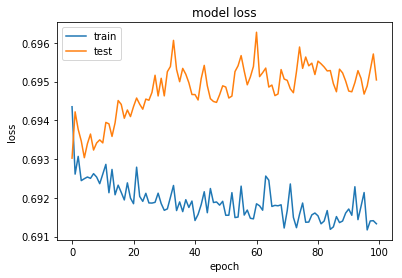

plotting accuracy:


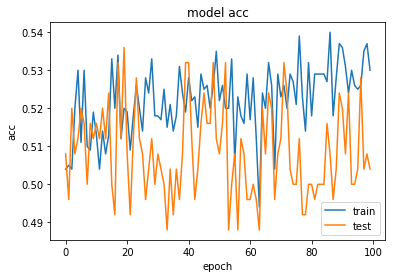

---------------------------------------------------------------------
---------------------------------------------------------------------
PROCESSING: ATTEMPT 2: add regularizers and batch normalization
250/250 [==============================] - 0s 94us/step
plotting loss:


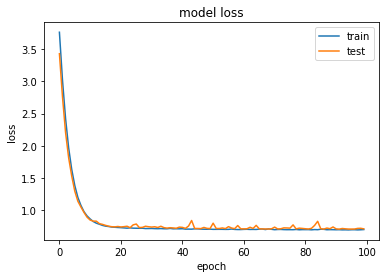

plotting accuracy:


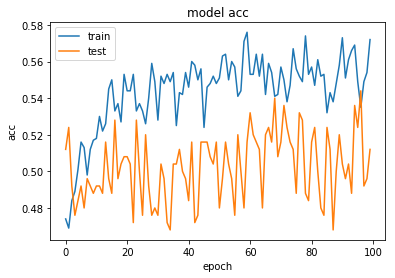

---------------------------------------------------------------------
---------------------------------------------------------------------
PROCESSING: ATTEMPT 3: add dropout and increase learning rate
250/250 [==============================] - 0s 59us/step
plotting loss:


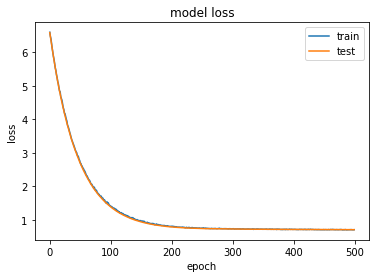

plotting accuracy:


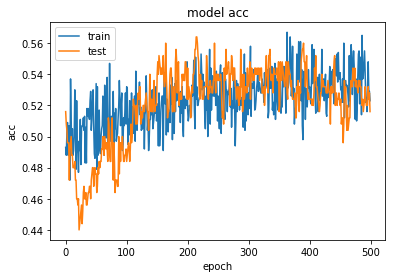

---------------------------------------------------------------------
---------------------------------------------------------------------


In [45]:
process_SP500_sv("ATTEMPT 1: simplest model possible", MLP_SV_step1(), epochs=100)
process_SP500_sv("ATTEMPT 2: add regularizers and batch normalization", MLP_SV_step2(), epochs=100)
process_SP500_sv("ATTEMPT 3: add dropout and increase learning rate", MLP_SV_step3(), epochs=500)